<a href="https://colab.research.google.com/github/altaga/Pytorch-Driving-Guardian/blob/main/Hardware%20Code/Jetson%20Code/Emotion%20detection/Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotions Monitor:

Testing Module

In this section we are going to download all the necessary files directly from the repository to be able to carry out the model tests.

In [ ]:
# Haarcascades files.
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
# Emotions Pytorch Model:
!wget https://github.com/altaga/Pytorch-Driving-Guardian/blob/main/Hardware%20Code/Jetson%20Code/Emotion%20detection/model/emotions.t7?raw=true -O emotions.t7
# Model and BackPropagation Utility.
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/Emotion%20detection/utils/model.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/Emotion%20detection/utils/grad_cam.py
# Testing Images
!wget https://i.ibb.co/wJJKymb/happy.png
!wget https://i.ibb.co/54RXTHv/sad.png
!wget https://i.ibb.co/VvtfzqT/neutral.png

Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import torch
import sys
from PIL import Image
import model
from grad_cam import BackPropagation, GradCAM,GuidedBackPropagation
import os

%matplotlib inline

Pytorch Convolutional Neural Network Architecture.

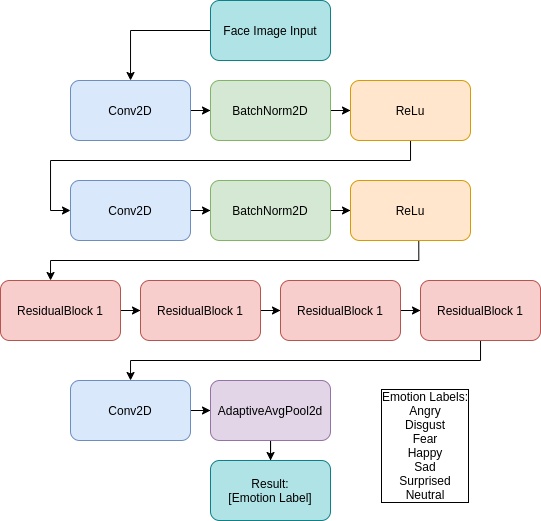

Layers:

- Input Layer: This layer has an input of (24, 24, 1), receiving the data from a 24px high and 24px long grayscale image.
- Conv2D: Convolutional layer for the generation of filters of the input images.
- BatchNorm2D: It helps the convolutional layer to normalize the values after that layer and it helps the network to accelerate its convergence in training.
  - https://arxiv.org/abs/1502.03167
- ReLu: with this layer we eliminate negative activations after each normalization.
- ResidualBlock: This type of block improves the performance of the network by making each one learn even more about the data we are looking to analyze, avoiding performance degradation by adding even more blocks.
  - https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

In [ ]:
import torch.nn as nn

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x

Setup Haarcascade Models and Setup CNN Input Shape, CNN classes and Global Variables.

In [ ]:
# We loaded the simple face detection model before image processing
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Input image shape
shape = (48,48)

# Name Classes
classes = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprised',
    'Neutral'
]

# Setting the GPU as the Main Processor Unit
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Configure all processes in smaller functions to carry out more structured programming.

In [ ]:
# Pre-processing for face detection before model with opencv
def preprocess(image_path):
    global faceCascade
    global shape
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    flag =0
    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)
        flag=1

    img = Image.fromarray(face).convert('L')
    inputs = transform_test(img)
    # Return detections into array
    return inputs, face, flag

# Plot the results for testing
def plotImage(path, mylabel):
    global shape
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.putText(img, mylabel, (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 7, (255, 0, 0), 10, cv2.LINE_AA)
    dimensions = img.shape
    height = img.shape[0]
    width = img.shape[1]
    plt.imshow(img)

# Emotion detection with Pytorch model
def detect_emotion(images, model_name):
    global classes
    global device
    flag=0
    for i, image in enumerate(images):
        target, raw_image,flag = preprocess(image['path'])
        image['image'] = target
        image['raw_image'] = raw_image

    net = model.Model(num_classes=len(classes)).to(device)
    checkpoint = torch.load(model_name, map_location=device)
    net.load_state_dict(checkpoint['net'])
    net.eval()
    result_images = []
    label = ""
    if(flag):
        for index, image in enumerate(images):
            img = torch.stack([image['image']]).to(device)
            bp = BackPropagation(model=net)
            probs, ids = bp.forward(img)
            actual_emotion = ids[:,0]
            label = classes[actual_emotion.data]
        plotImage(image['path'],label)
    else:
        plotImage(image['path'],label)
    return label

In this section we will show the 3 examples we did to show that the model works.

In [ ]:
detect_emotion(images=[{'path': 'neutral.png'}],model_name='emotions.t7')

In [ ]:
detect_emotion(images=[{'path': 'happy.png'}],model_name='emotions.t7')

In [ ]:
detect_emotion(images=[{'path': 'sad.png'}],model_name='emotions.t7')